In [1]:
import pyro
import torch
import wandb
import os

from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean
from inference.bayesian.models import TorchModel, BayesianModel
from inference.bayesian.utils import plot_forecast
from inference.inference import inference
from ESN.utils import run_esn

In [2]:
config = {
            "dataset": "acea",
            "model_widths": [500, 70, 1],
            "activation": "tanh",
            "distributions": ["gauss", "unif", "gauss"],
            "parameters": [[0,1],[0,10]],
            "dim_reduction": False,
            "num_samples": 2000,
            "inference": "svi",
            "lr": 0.03,
            "num_iterations": 5000,
            "plot": False
            }

os.environ["WANDB_MODE"]="offline"
wandb.init(project="bayes_rc", config=config)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]='0'

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
Ytr, train_embedding, Yval, val_embedding, Yte, test_embedding = run_esn(config.dataset, device, dim_reduction=config.dim_reduction)

Tr: 16010, Val: 3431, Te: 3431


# SVI

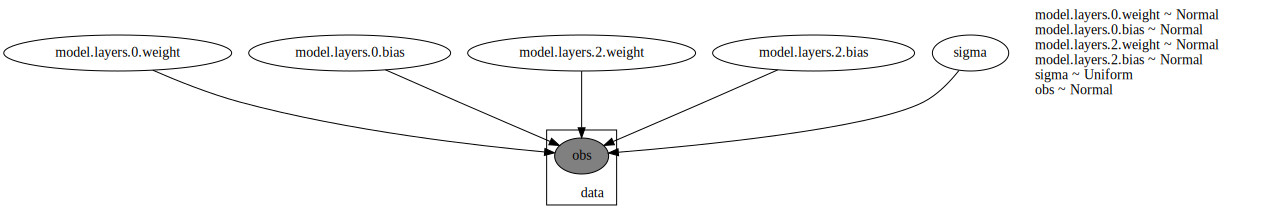

In [5]:
torch_model = TorchModel(config.model_widths, config.activation).to(device)
svi_model = BayesianModel(torch_model, config, device)
svi_model.render_model(model_args=(train_embedding[0], Ytr[0]))

Autoguide for testing

In [6]:
pyro.clear_param_store()

# To enforce all the parameters in the guide on the GPU, since we use an autoguide
if device != 'cpu':
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

guide = AutoMultivariateNormal(svi_model, init_loc_fn=init_to_mean)
# pyro.render_model(guide, model_args=(train_embedding[0], Ytr[0]), render_distributions=True)

In [7]:
def debug_memory():
    import collections, gc, resource, torch
    print('maxrss = {}'.format(
        resource.getrusage(resource.RUSAGE_SELF).ru_maxrss))
    tensors = collections.Counter(
        (str(o.device), str(o.dtype), tuple(o.shape))
        for o in gc.get_objects()
        if torch.is_tensor(o)
    )
    for line in sorted(tensors.items()):
        print('{}\t{}'.format(*line))

In [8]:
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, Predictive
from tqdm import trange

In [9]:
from contextlib import redirect_stdout

Y, X = Ytr, train_embedding

with open('out.txt', 'a') as f:
    with redirect_stdout(f):
        debug_memory()
        pyro.clear_param_store()

        optim = Adam({"lr": 0.01})
        svi = SVI(svi_model, guide, optim, loss=Trace_ELBO())

        with trange(50) as t:
            for j in t:
                print(f"Epoch {j} ")
                print(f"GPU: {torch.cuda.memory_allocated(device)}")
                debug_memory()
                # calculate the loss and take a gradient step
                loss = svi.step(X, Y)
                # display progress bar
                t.set_description(f"Epoch {j+1}")
                t.set_postfix({"loss":loss / Y.shape[0]})

/home/michele/anaconda3/envs/uncertainty/lib/python3.10/site-packages/torch/distributed/distributed_c10d.py:262: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(
Epoch 2:   4%|▍         | 2/50 [00:00<00:22,  2.13it/s, loss=6.48]/home/michele/anaconda3/envs/uncertainty/lib/python3.10/site-packages/pyro/poutine/trace_struct.py:285: UserWarning: Encountered NaN: log_prob_sum at site '_AutoMultivariateNormal_latent'
  warn_if_nan(
/home/michele/anaconda3/envs/uncertainty/lib/python3.10/site-packages/pyro/infer/trace_elbo.py:158: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
Epoch 3:   6%|▌         | 3/50 [00:01<00:23,  1.98it/s, loss=nan] 


ValueError: Expected parameter loc (Tensor of shape (35142,)) of distribution MultivariateNormal(loc: torch.Size([35142]), scale_tril: torch.Size([35142, 35142])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([nan, nan, nan,  ..., nan, nan, nan], grad_fn=<ExpandBackward0>)
                    Trace Shapes:            
                     Param Sites:            
     AutoMultivariateNormal.scale       35142
AutoMultivariateNormal.scale_tril 35142 35142
       AutoMultivariateNormal.loc       35142
                    Sample Sites:            

In [8]:
Y, X = Ytr, train_embedding

x_batches = [X[i:(i+1),:] for i in range(int(X.shape[0]))]
y_batches = [Y[i:(i+1)] for i in range(int(Y.shape[0]))]

In [ ]:
pyro.clear_param_store()

optim = Adam({"lr": 0.03})
svi = SVI(svi_model, guide, optim, loss=Trace_ELBO())

with trange(50) as t:
    for j in t:
        for x, y in zip(x_batches, y_batches):
            # calculate the loss and take a gradient step
            loss = svi.step(x, y)

        # display progress bar
        t.set_description(f"Epoch {j+1}")
        t.set_postfix({"loss":loss / Y.shape[0]})

In [ ]:
predictive = Predictive(svi_model, guide=guide, num_samples=2000)(x=test_embedding, y=None)

In [7]:
predictive, diagnostics = inference(config, svi_model, guide, X_train=train_embedding, Y_train=Ytr, 
                                    X_test=test_embedding[:50,:], Y_test=Yte[:50])

Epoch 6:   0%|          | 3/5000 [00:00<03:09, 26.36it/s, loss=-1.25e+6]/home/michele/anaconda3/envs/uncertainty/lib/python3.10/site-packages/pyro/poutine/trace_struct.py:285: UserWarning: Encountered NaN: log_prob_sum at site '_AutoMultivariateNormal_latent'
  warn_if_nan(
/home/michele/anaconda3/envs/uncertainty/lib/python3.10/site-packages/pyro/infer/trace_elbo.py:158: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
Epoch 7:   0%|          | 7/5000 [00:00<02:03, 40.37it/s, loss=nan]     


ValueError: Expected parameter loc (Tensor of shape (5022,)) of distribution MultivariateNormal(loc: torch.Size([5022]), scale_tril: torch.Size([5022, 5022])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([nan, nan, nan,  ..., nan, nan, nan], grad_fn=<ExpandBackward0>)
                    Trace Shapes:          
                     Param Sites:          
     AutoMultivariateNormal.scale      5022
AutoMultivariateNormal.scale_tril 5022 5022
       AutoMultivariateNormal.loc      5022
                    Sample Sites:          

In [12]:
from pyro.infer import Predictive

In [22]:
predictive['obs'] = torch.stack([Predictive(svi_model, guide=guide, num_samples=2000)(x=test_embedding[i*50:(i+1)*50,:], y=None)['obs'] for i in range(int(test_embedding.shape[0]/50))])

In [17]:
predictive['obs'] = predictive['obs'].reshape((68*2000,50))

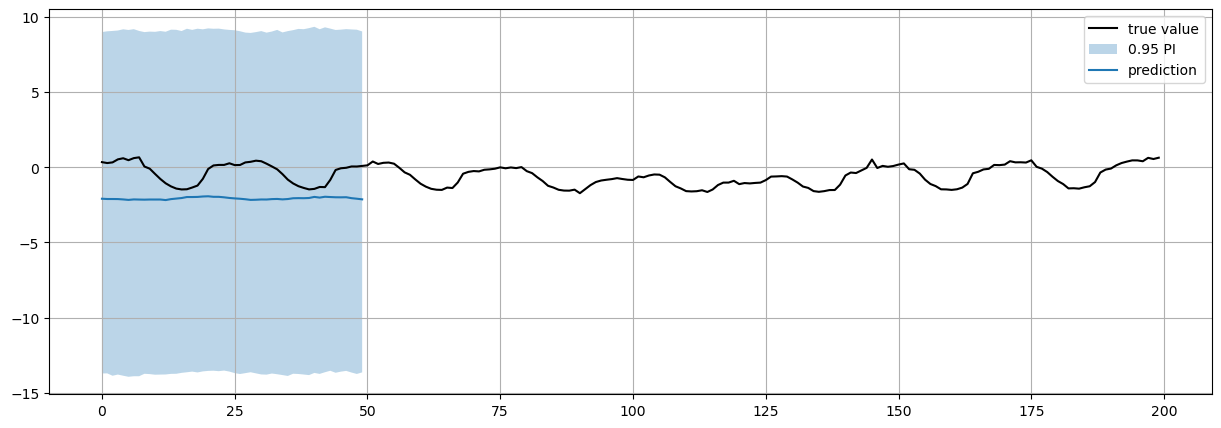

In [19]:
plot_forecast(predictive, Yte, "svi")

In [9]:
for k, v in diagnostics.items():
    print(k)

train_time
quantiles
cal_error
crps


In [9]:
print("training time: ", diagnostics['train_time'])
print("calibration error: ", diagnostics['cal_error'])
print("Continuous ranked probability score: ", diagnostics['crps'])

training time:  0.125
calibration error:  113.52652029035886
Continuous ranked probability score:  9.770601272583008


In [ ]:
# to save a session
import dill

dill.dump_session('dump/notebook_16122022.db')

In [ ]:
# to load a session
dill.load_session('notebook_env.db')